In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from sklearn import preprocessing, metrics
import utils
import scipy.io
import numpy as np
from linear_classifier import LinearSVM_twoclass

# load the SPAM email training dataset

N_train = 3600

X,y = utils.load_mat('data/spamTrain.mat')
yy = np.ones(y.shape)
yy[y==0] = -1

X_train = X[:N_train] # <--- training data
yy_train = yy[:N_train] # <--- training label

X_val = X[N_train:] # <--- validation data
yy_val = yy[N_train:] # <--- validation label

# load the SPAM email test dataset

test_data = scipy.io.loadmat('data/spamTest.mat')
X_test = test_data['Xtest'] # <--- testing label
y_test = test_data['ytest'].flatten()

yy_test = np.ones(y_test.shape)
yy_test[y_test == 0] = -1 # <--- testing label



In [22]:
##################################################################################
#  YOUR CODE HERE for training the best performing SVM for the data above.       #
#  what should C be? What should num_iters be? Should X be scaled?               #
#  should X be kernelized? What should the learning rate be? What should the     #
#  number of iterations be?                                                      #
##################################################################################

sigma = 10.0
K = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
scaler = preprocessing.StandardScaler().fit(K)
scaleK = scaler.transform(K)
KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

Kval = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
# scalerval = preprocessing.StandardScaler().fit(Kval)
scaleKval = scaler.transform(Kval)
KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

Ktest = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_test for x2 in X_train]).reshape(X_test.shape[0],X_train.shape[0])
# scalertest = preprocessing.StandardScaler().fit(Ktest)
scaleKtest = scaler.transform(Ktest)
KKtest = np.vstack([np.ones((scaleKtest.shape[0],)),scaleKtest.T]).T


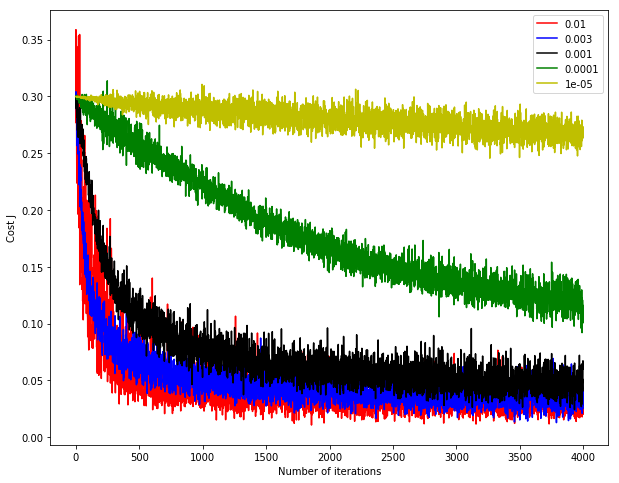

In [69]:
# choose learning rate
color = ['r','b','k','g','y','m']
LearningRatevals = [1e-2,3e-3,1e-3,1e-4,1e-5]
color_idx = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for LR in LearningRatevals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=LR,reg=0.3,num_iters=4000,verbose=False,batch_size=200)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in LearningRatevals])
plt.show()
fig.savefig("./fig_learning_rate.pdf", format='pdf')

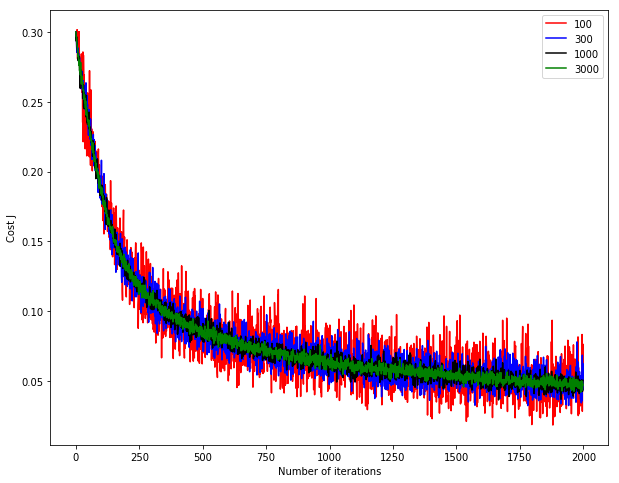

In [86]:
# choose batch size
Best_learning_rate = 1e-3
BatchSizes = [100,300,1000,3000]
color_idx = 0
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for BS in BatchSizes:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=0.3,num_iters=2000,verbose=False,batch_size=BS)
    plt.plot(range(len(J_history)), J_history, color[color_idx])
    color_idx += 1
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.legend([str(a) for a in BatchSizes])
plt.show()
fig.savefig("./fig_batch_size.pdf", format='pdf')

In [72]:
# choose C
Best_batch_size=300
Cvals = [0.01,0.03,0.1,0.3,1,3,10,30,100,300]
for C in Cvals:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=C,num_iters=2000,verbose=False,batch_size=Best_batch_size)
    yy_pred_train = svm.predict(KK)
    accuracy_train = np.mean(yy_pred_train == yy_train)
    yy_pred_val = svm.predict(KKval)
    accuracy_val = np.mean(yy_pred_val == yy_val)
    print "C:\t", C, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val

C:	0.01 , training accuracy:	0.8 , validation accuracy:	0.8075
C:	0.03 , training accuracy:	0.909722222222 , validation accuracy:	0.92
C:	0.1 , training accuracy:	0.92 , validation accuracy:	0.9225
C:	0.3 , training accuracy:	0.948611111111 , validation accuracy:	0.94
C:	1 , training accuracy:	0.9625 , validation accuracy:	0.96
C:	3 , training accuracy:	0.965833333333 , validation accuracy:	0.9575
C:	10 , training accuracy:	0.967777777778 , validation accuracy:	0.965
C:	30 , training accuracy:	0.975555555556 , validation accuracy:	0.9725
C:	100 , training accuracy:	0.968611111111 , validation accuracy:	0.9675
C:	300 , training accuracy:	0.97 , validation accuracy:	0.965


In [74]:
# choose sigma
Best_C = 30.0
Sigmas = [1,10,100]
for sigma in Sigmas:
    K = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
    scaler = preprocessing.StandardScaler().fit(K)
    scaleK = scaler.transform(K)
    KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

    Kval = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
#     scalerval = preprocessing.StandardScaler().fit(Kval)
    scaleKval = scaler.transform(Kval)
    KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

    Ktest = np.array([utils.gaussian_kernel(x1,x2,sigma) for x1 in X_test for x2 in X_train]).reshape(X_test.shape[0],X_train.shape[0])
#     scalertest = preprocessing.StandardScaler().fit(Ktest)
    scaleKtest = scaler.transform(Ktest)
    KKtest = np.vstack([np.ones((scaleKtest.shape[0],)),scaleKtest.T]).T
    
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=Best_C,num_iters=2000,verbose=False,batch_size=Best_batch_size)
    yy_pred_train = svm.predict(KK)
    accuracy_train = np.mean(yy_pred_train == yy_train)
    yy_pred_val = svm.predict(KKval)
    accuracy_val = np.mean(yy_pred_val == yy_val)
    print "sigma:\t", sigma, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val

sigma:	1 , training accuracy:	1.0 , validation accuracy:	0.78
sigma:	10 , training accuracy:	0.978333333333 , validation accuracy:	0.97
sigma:	100 , training accuracy:	0.972777777778 , validation accuracy:	0.9675


In [87]:
# choose iteration
Best_sigma = 10

K = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
scaler = preprocessing.StandardScaler().fit(K)
scaleK = scaler.transform(K)
KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

Kval = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
# scalerval = preprocessing.StandardScaler().fit(Kval)
scaleKval = scaler.transform(Kval)
KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

Iterations = [100,300,1000,3000,10000, 30000]
for iteration in Iterations:
    svm = LinearSVM_twoclass()
    svm.theta = np.zeros((KK.shape[1],))
    J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=Best_C,num_iters=iteration,verbose=False,batch_size=Best_batch_size)
    yy_pred_train = svm.predict(KK)
    accuracy_train = np.mean(yy_pred_train == yy_train)
    yy_pred_val = svm.predict(KKval)
    accuracy_val = np.mean(yy_pred_val == yy_val)
    print "iteration:\t", iteration, ", training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val

iteration:	100 , training accuracy:	0.590277777778 , validation accuracy:	0.545
iteration:	300 , training accuracy:	0.945555555556 , validation accuracy:	0.945
iteration:	1000 , training accuracy:	0.809166666667 , validation accuracy:	0.7975
iteration:	3000 , training accuracy:	0.981666666667 , validation accuracy:	0.9725
iteration:	10000 , training accuracy:	0.988333333333 , validation accuracy:	0.965
iteration:	30000 , training accuracy:	0.996388888889 , validation accuracy:	0.97


In [77]:
Best_C = 30
Best_sigma = 10
Best_iteration = 10000
Best_learning_rate = 0.001
Best_accuracy = 0.0


##################################################################################
# YOUR CODE HERE for testing your best model's performance                       #
# what is the accuracy of your best model on the test set? On the training set?  #
##################################################################################
K = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_train for x2 in X_train]).reshape(X_train.shape[0],X_train.shape[0])
scaler = preprocessing.StandardScaler().fit(K)
scaleK = scaler.transform(K)
KK = np.vstack([np.ones((scaleK.shape[0],)),scaleK.T]).T

Kval = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_val for x2 in X_train]).reshape(X_val.shape[0],X_train.shape[0])
# scalerval = preprocessing.StandardScaler().fit(Kval)
scaleKval = scaler.transform(Kval)
KKval = np.vstack([np.ones((scaleKval.shape[0],)),scaleKval.T]).T

Ktest = np.array([utils.gaussian_kernel(x1,x2,Best_sigma) for x1 in X_test for x2 in X_train]).reshape(X_test.shape[0],X_train.shape[0])
# scalertest = preprocessing.StandardScaler().fit(Ktest)
scaleKtest = scaler.transform(Ktest)
KKtest = np.vstack([np.ones((scaleKtest.shape[0],)),scaleKtest.T]).T

svm = LinearSVM_twoclass()
svm.theta = np.zeros((KK.shape[1],))

##################################################################################
# YOUR CODE HERE for testing your best model's performance                       #
# what is the accuracy of your best model on the test set? On the training set?  #
##################################################################################

J_history = svm.train(KK,yy_train,learning_rate=Best_learning_rate,reg=Best_C,num_iters=Best_iteration,verbose=True,batch_size=Best_batch_size)
yy_pred_train = svm.predict(KK)
accuracy_train = np.mean(yy_pred_train == yy_train)
yy_pred_val = svm.predict(KKval)
accuracy_val = np.mean(yy_pred_val == yy_val)
yy_pred_test = svm.predict(KKtest)
accuracy_test = np.mean(yy_pred_test == yy_test)
print "training accuracy:\t", accuracy_train, ", validation accuracy:\t", accuracy_val, ", testing accuracy:\t", accuracy_test


iteration 0 / 10000: loss 30.000000
iteration 100 / 10000: loss 55.564658
iteration 200 / 10000: loss 37.671409
iteration 300 / 10000: loss 7.613762
iteration 400 / 10000: loss 6.714172
iteration 500 / 10000: loss 21.349503
iteration 600 / 10000: loss 30.247044
iteration 700 / 10000: loss 10.276132
iteration 800 / 10000: loss 13.917776
iteration 900 / 10000: loss 5.853377
iteration 1000 / 10000: loss 54.851396
iteration 1100 / 10000: loss 4.323760
iteration 1200 / 10000: loss 3.667122
iteration 1300 / 10000: loss 5.675455
iteration 1400 / 10000: loss 4.160529
iteration 1500 / 10000: loss 27.906046
iteration 1600 / 10000: loss 0.875650
iteration 1700 / 10000: loss 4.617058
iteration 1800 / 10000: loss 4.505675
iteration 1900 / 10000: loss 3.307573
iteration 2000 / 10000: loss 6.655327
iteration 2100 / 10000: loss 2.662848
iteration 2200 / 10000: loss 46.571521
iteration 2300 / 10000: loss 3.992063
iteration 2400 / 10000: loss 1.424395
iteration 2500 / 10000: loss 0.940607
iteration 2600

In [90]:
##################################################################################
# ANALYSIS OF MODEL: Print the top 15 words that are predictive of spam and for  #
# ham. Hint: use the coefficient values of the learned model                     #
##################################################################################
words, inv_words = utils.get_vocab_dict()
print "============ top 15 spam ============"
for a in np.dot(svm.theta[1:],X_train).argsort()[-15:][::-1]:
    print words[a+1]
print "============ top 15 ham ============"    
for a in np.dot(svm.theta[1:],X_train).argsort()[:15][::-1]:
    print words[a+1]     
##################################################################################
#                    END OF YOUR CODE                                            #
##################################################################################

============ top 15 spam ============
remov
click
our
dollarnumb
monei
guarante
will
within
dollar
here
inform
free
market
hundr
hour
============ top 15 ham ============
network
version
set
chang
were
would
seem
thei
file
run
user
httpaddr
wrote
url
date
